Hi, guys.

This is my first join the Kaggle competition and write code in python (I used R before, and my best score in this competition also is made by R). So, I hope you all can help me to correct my error and misunderstanding of any concept and process (especially the stacking ensemble part).

In this note book, I try to roughly implement the whole workflow. here is the composition of my code:

[1]. import and load data

[2]. Data Cleansing 

[3]. EDA

[4]. Feature Engineering

[5]. Modeling selection 

[6]. Ensemble Generation


Here is a wired question I find: in the grid search part, I use 'random_state' or 'seed' to control the Randomness, but I find the best parameter is lightly different each time.

In [100]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [6]:
# load data set
df_train = pd.read_csv('../input/titanic/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_test = pd.read_csv('../input/titanic/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
# remove the "Survived" column in "df_train" and join bind two sets
df = pd.concat([df_train.drop("Survived", axis=1), df_test])
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# remove all string columns: "Name", "Ticket", "Cabin"
df = df.drop(["Name", "Ticket", "Cabin"], axis = 1)
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S


# Data Cleansing

In [12]:
# check missing value
df.isna().sum()

PassengerId      0
Pclass           0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             1
Embarked         2
dtype: int64

In [13]:
# deal with NA in Age
df[df.Age.isna()]
# there are many rows contain NA in Age columns and I use the median Age to replace the NA
df.Age = df.Age.fillna(df.Age.median())

# deal with NA in Fare
df[df.Fare.isna()]
# it is a 3th class passenger and there is strongly relationship between Fare and Class,so I use the mean(Fare) in 3th class to replace the missing value
df.Fare = df.Fare.fillna(df.Fare[df.Pclass ==3].median())

# deal with NA in Embarked
df[df.Embarked.isna()]
# the Embarked is independent, so I use mode to replace the NA
df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

In [14]:
# check missing value again
df.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [15]:
# update the df_train
df_train.Age = df.Age[0:len(df_train)]
df_train.Fare = df.Fare[0:len(df_train)]
df_train.Embarked = df.Embarked[0:len(df_train)]

# EDA
In the EDA part, I have two tasks:

First, check all variables' distribution.

Second, check the relationship between survived and other variables in df_train

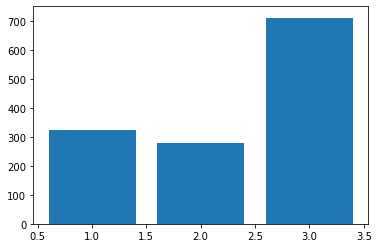

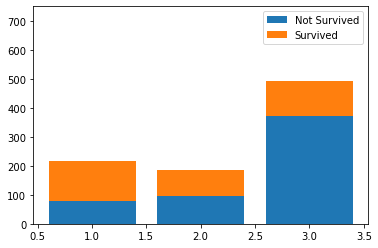

In [16]:
# Pclass
ind = list(set(df.Pclass))
count = df.groupby("Pclass").count().Sex
count0 = df_train[df_train.Survived == 0].groupby("Pclass").count().Sex
count1 = df_train[df_train.Survived == 1].groupby("Pclass").count().Sex

# distrubition
plt.bar(ind, count)
plt.ylim(0,750)
plt.show()

# relationship
p0 = plt.bar(ind, count0)
p1 = plt.bar(ind, count1, bottom = count0)
plt.ylim(0,750)
plt.legend((p0[0], p1[0]), ('Not Survived','Survived'))
plt.show()

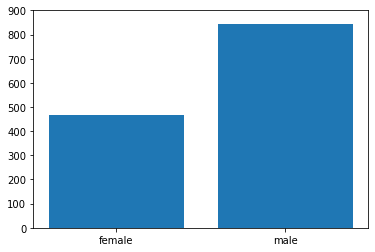

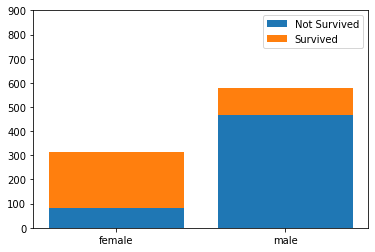

In [17]:
# Sex
ind = sorted(list(set(df.Sex)))
count = df.groupby("Sex").count().Pclass
count0 = df_train[df_train.Survived == 0].groupby("Sex").count().Survived
count1 = df_train[df_train.Survived == 1].groupby("Sex").count().Survived

# distrubition
plt.bar(ind, count)
plt.ylim(0,900)
plt.show()

# relationship
p0 = plt.bar(ind, count0)
p1 = plt.bar(ind, count1, bottom = count0)
plt.ylim(0,900)
plt.legend((p0[0], p1[0]), ('Not Survived','Survived'))
plt.show()

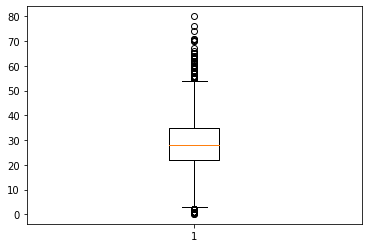

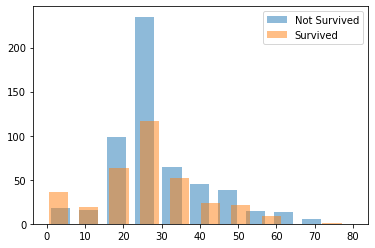

In [18]:
# Age
#distribution
plt.boxplot(df.Age)
plt.show()

#relationship
p0 = plt.hist(df_train.Age[df_train.Survived == 0], width = 5, alpha = 0.5)
p1 = plt.hist(df_train.Age[df_train.Survived == 1], width = 5, alpha = 0.5)
plt.legend(('Not Survived','Survived'))
plt.show()

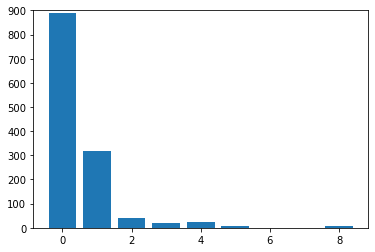

total  Percentage
SibSp Survived                   
0     0           398   65.460526
      1           210   34.539474
1     0            97   46.411483
      1           112   53.588517
2     0            15   53.571429
      1            13   46.428571
3     0            12   75.000000
      1             4   25.000000
4     0            15   83.333333
      1             3   16.666667
5     0             5  100.000000
8     0             7  100.000000

In [19]:
# SibSp
ind = list(set(df.SibSp))
count = df.groupby("SibSp").count().Pclass

# distrubition
plt.bar(ind, count)
plt.ylim(0,900)
plt.show()

# relationship
sib = df_train.groupby(['SibSp','Survived']).agg(total=('Pclass', 'size'))
sib["Percentage"] = sib / sib.groupby(level=0).sum() *100
sib

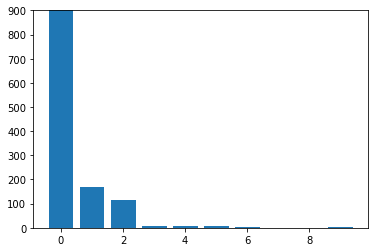

total  Percentage
Parch Survived                   
0     0           445   65.634218
      1           233   34.365782
1     0            53   44.915254
      1            65   55.084746
2     0            40   50.000000
      1            40   50.000000
3     0             2   40.000000
      1             3   60.000000
4     0             4  100.000000
5     0             4   80.000000
      1             1   20.000000
6     0             1  100.000000

In [20]:
# Parch
ind = list(set(df.Parch))
count = df.groupby("Parch").count().Pclass

# distrubition
plt.bar(ind, count)
plt.ylim(0,900)
plt.show()

# relationship
par = df_train.groupby(['Parch','Survived']).agg(total=('Pclass', 'size'))
par["Percentage"] = par / par.groupby(level=0).sum() *100
par

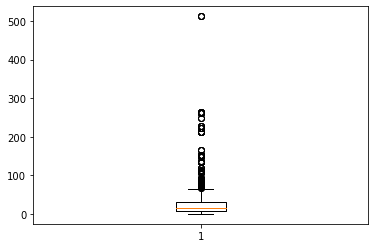

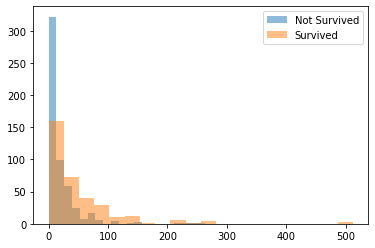

In [21]:
# Fare
#distribution
plt.boxplot(df.Fare)
plt.show()

#relationship
p1 = plt.hist(df_train.Fare[df_train.Survived == 0], bins = 20, alpha = 0.5)
p2 = plt.hist(df_train.Fare[df_train.Survived == 1], bins = 20, alpha = 0.5)
plt.legend(('Not Survived','Survived'))
plt.show()

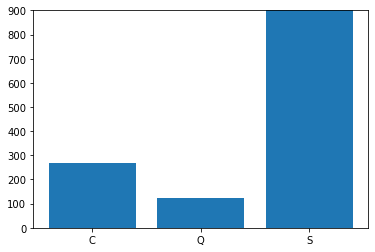

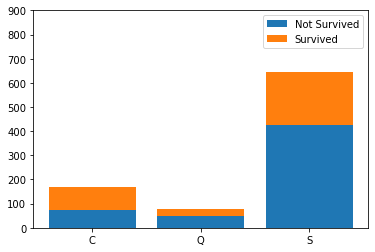

In [22]:
# Embarked
ind = sorted(list(set(df.Embarked)))
count = df.groupby("Embarked").count().Pclass
count0 = df_train[df_train.Survived == 0].groupby("Embarked").count().Survived
count1 = df_train[df_train.Survived == 1].groupby("Embarked").count().Survived

# distrubition
plt.bar(ind, count)
plt.ylim(0,900)
plt.show()

# relationship
p0 = plt.bar(ind, count0)
p1 = plt.bar(ind, count1, bottom = count0)
plt.ylim(0,900)
plt.legend((p0[0], p1[0]), ('Not Survived','Survived'))
plt.show()

# Feature Engineering

In [23]:
#Encode Features
#Sex 0: female, 1: male
df.Sex = df.Sex.replace("female", 0)
df.Sex = df.Sex.replace("male", 1)

#Embarked 0:C, 1:Q, 2:S
df.Embarked = df.Embarked.replace("C",0)
df.Embarked = df.Embarked.replace("Q",1)
df.Embarked = df.Embarked.replace("S",2)

In [24]:
#genearate dummy variables for Pclass, SibSp, Parch, and Embarked
df_dummy = pd.get_dummies(df, columns = ['Pclass', 'SibSp', 'Parch', 'Embarked'])

In [25]:
# create train and test sets
train_x = df_dummy[0:len(df_train)]
train_y = df_train.Survived
train_x

,PassengerId,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_0,Embarked_1,Embarked_2
0,1,1,22.0,7.2500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,38.0,71.2833,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0,26.0,7.9250,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,35.0,53.1000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1,35.0,8.0500,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,27.0,13.0000,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
887,888,0,19.0,30.0000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
888,889,0,28.0,23.4500,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
889,890,1,26.0,30.0000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


<BarContainer object of 25 artists>

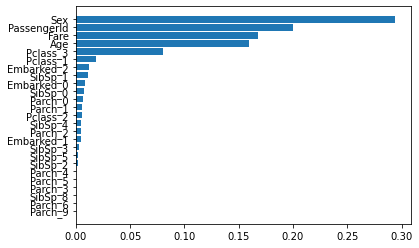

In [26]:
# check the feature inportance by randomforest
model_rf = RandomForestRegressor()
model_rf.fit(train_x, train_y)

ind =  model_rf.feature_importances_.argsort()
plt.barh(train_x.columns[ind], model_rf.feature_importances_[ind])

In [ ]:
# some Prach and SibSp dummy variables are low importance and only exist in the train set or test set. So, I plan to encode them and reduce the number of feature
# in SibSp, 0: 0 ,1: 1, 2: 2+
# in Parch, 0: 0, 1: 1, 2: 2+
df.loc[df.SibSp >= 2, 'SibSp'] = 2
df.loc[df.Parch >= 2, 'Parch'] = 2

df.head()

In [27]:
#repeat. geneate dummy variables and create train and test sets
df_dummy = pd.get_dummies(df, columns = ['Pclass', 'SibSp', 'Parch', 'Embarked'])

# create train and test sets
train_x = df_dummy[0:len(df_train)]
train_y = df_train.Survived
test_x = df_dummy[len(df_train):]

# Model Selection

In [ ]:
# model list used in this case
models = ["Random Forest", "Xgboost", "Extra Randomized Trees"]
scores = []

In [41]:
# Grid Search
# Random Forset
grid_rf = {
    "n_estimators": np.linspace(100,1000,5, dtype = int),
    "max_depth": [3,5,7],
    "max_features": [2,3,4,5,6,7,8,9],
    "min_samples_leaf": [3,5,7],
    "min_samples_split":[3,5,7],
    "random_state": [2020,2021]
}

model_rf = RandomForestClassifier()
search_rf = GridSearchCV(estimator = model_rf, 
                         param_grid = grid_rf, 
                         cv = 5,
                         n_jobs = -1,
                         verbose = 2)

In [42]:
# do not run this code in your local PC, it is time consuming
search_rf.fit(train_x, train_y)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': array([ 100,  325,  550,  775, 1000]),
                         'random_state': [2020, 2021]},
             verbose=2)

In [69]:
# find the best parameters
best_rf = search_rf.best_params_
best_rf

{'max_depth': 7,
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 100,
 'random_state': 2020}

In [66]:
# it seems RandomForestRegressor cannot accept the dict type parameters, so I have to rewrite the best parameters
final_rf =  RandomForestClassifier(**best_rf)
final_rf.fit(train_x, train_y)
pred_rf = final_rf.predict(test_x)
pred_rf

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [34]:
# Xgboost
grid_xgb = {
    'booster': ['gbtree', 'gblinear'],
    'objective': ['binary:logistic'],
    'subsample': [0.6,0.7,0.8,0.9],
    'colsample_bytree': [0.6,0.7,0.8,0.9],
    'eta': [0.05,0.1,0.2,0.3],
    'max_depth': [3,5,7],
    'seed': [2021,2022],
    'eval_metric': ['logloss']
}


model_xgb = xgb.XGBClassifier()
search_xgb = GridSearchCV(estimator = model_xgb, 
                         param_grid = grid_xgb, 
                         cv = 5,
                         n_jobs = -1,
                         verbose = 2)

In [35]:
# do not run this code in your local PC, it is time consuming
search_xgb.fit(train_x, train_y)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2084 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [68]:
# find the best parameters
best_xgb = search_xgb.best_params_
best_xgb

{'booster': 'gbtree',
 'colsample_bytree': 0.7,
 'eta': 0.05,
 'eval_metric': 'logloss',
 'max_depth': 7,
 'objective': 'binary:logistic',
 'seed': 2021,
 'subsample': 0.6}

In [56]:
# final xgboost model
final_xgb = xgb.XGBClassifier(**best_xgb)
final_xgb.fit(train_x, train_y)
pred_xgb = final_xgb.predict(test_x)
pred_xgb

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [57]:
# Extra Randomized Trees. this part is very simular with random forest, so I copy my code to here
grid_ert = {
    "n_estimators": np.linspace(100,1000,5, dtype = int),
    "max_depth": [3,5,7],
    "max_features": [2,3,4,5,6,7,8,9],
    "min_samples_leaf": [3,5,7],
    "min_samples_split":[3,5,7],
    "random_state": [2020,2021]
}

model_ert = ExtraTreesClassifier()
search_ert = GridSearchCV(estimator = model_ert, 
                         param_grid = grid_ert, 
                         cv = 5,
                         n_jobs = -1,
                         verbose = 2)

In [58]:
# do not run this code in your local PC, it is time consuming
search_ert.fit(train_x, train_y)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': array([ 100,  325,  550,  775, 1000]),
                         'random_state': [2020, 2021]},
             verbose=2)

In [67]:
# find the best parameters
best_ert = search_ert.best_params_
best_ert

{'max_depth': 5,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 325,
 'random_state': 2020}

In [63]:
# final Extra Randomized Trees model
final_ert =  ExtraTreesClassifier(**best_ert)
final_ert.fit(train_x, train_y)
pred_ert = final_ert.predict(test_x)
pred_ert

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Ensemble Generation

In [97]:
# a majority vote ensemble
def ensumble_majority(trainx, trainy, testx):
    final_rf =  RandomForestClassifier(**best_rf)
    final_rf.fit(trainx, trainy)
    pred_rf = final_rf.predict(testx)
    
    final_ert =  ExtraTreesClassifier(**best_ert)
    final_ert.fit(trainx, trainy)
    pred_ert = final_rf.predict(testx)
    
    final_xgb = xgb.XGBClassifier(**best_xgb)
    final_xgb.fit(trainx, trainy)
    pred_xgb = final_xgb.predict(testx)
    
    collection = pd.DataFrame({'pred_rf':pred_rf,'pred_ert':pred_ert,'pred_xgb':pred_xgb})
    collection['sum'] = collection.sum(axis = 1)
    collection.loc[collection['sum'] > 1.5, 'pred'] = 1
    collection.loc[collection['sum'] < 1.5, 'pred'] = 0
    
    return(collection.pred)
    

In [99]:
pred = ensumble_majority(train_x, train_y, test_x)

res = pd.DataFrame({'PassengerId':test_x.PassengerId, 'Survived': pred})
res.to_csv('result.csv', index=False)

In [102]:
# a simple ensemble can use the majority vote rule, but here I try to build a simple stacking ensemble.
# I use random forest and Extra Randomized Trees as basic models, and choose xgboost as the second layer models

def ensemble_stacking(trainx, trainy, testx):
    '''
    this function is to ensemble three models' predictions: random forest, extra randomized trees, and xgboost
    '''
    # first, split the train set into two equal parts.
    px1,px2, py1, py2 = train_test_split(trainx, trainy, random_state= 2021, test_size=0.5)
    
    # second, train basic models by the two sets.
    # random forest
    final_rf =  RandomForestClassifier(**best_rf)
    final_rf.fit(px1,py1)
    pred_rf = final_rf.predict(px2)
    
    
    # extra randomize trees
    final_ert =  ExtraTreesClassifier(**best_ert)
    final_ert.fit(px2,py2)
    pred_ert = final_ert.predict(px1)
    
    # third, combind the two basic models predictions and as a new feature add into the original train set.
    # it means to create a new train setand the new set = original train set + tow basic models' predictions
    
    new_x = pd.concat([px1, px2])
    new_y = pd.concat([py1, py2])
    feature = np.concatenate([pred_ert,pred_rf])
    new_x['feature'] = feature
    
    # finally, train xgboost model by the new set and make the final prediction.
    
    final_xgb = xgb.XGBClassifier(**best_xgb)
    final_xgb.fit(train_x, train_y)
    pred_xgb = final_xgb.predict(test_x)
    pred_xgb
    
    return(pred_xgb)

In [105]:
# call ensemble function
pred = ensemble_stacking(train_x, train_y, test_x)

In [106]:
res = pd.DataFrame({'PassengerId':test_x.PassengerId, 'Survived': pred})
res.to_csv('result_stacking.csv', index=False)

Thank you for viewing my notebook!
I want to share some of my experiences here.

[1] more try, more findings. I check every model I used in this competition. I find some models can get better scores and parts of models' predictions are better than the ensemble result. (In R, I try more than 10 models, but in Python, I just choose 3 models.)

[2] string columns are very important. In my code, I delete all string columns because I don't know how to deal with them. But I notice that many high score notebooks extract information from the string columns and generate features finally. So, I guess that is why I cannot reach the top 10% :(

[3] Generating FEATURES! I think the most important step in the whole process is to determine features. The quality of features determines your score's mean value, and the rest parts, like grid search and ensemble, are the sd of your score. Therefore, if you want to get a higher score, pay more attention to your features.